# 对海洋数据进行hilbert EOF 分解

## 下载数据
*数据来源于欧洲哥白尼数据中心全球海洋再分析数据(表层盐度月平均) ,利用其提供的Python API快捷下载* (`conda install copernicusmarine -c conda-forge`)    
***(注意：新用户需要注册)***

---
**维度**
  
- **time**：`2001-01~2020-12`
- **lon**：`30°E~140°E`
- **lat**：`20°S~31°N`
- **variables**:`so`
---
**链接**
- [https://data.marine.copernicus.eu/product/GLOBAL_MULTIYEAR_PHY_001_030/services]
  ![](./homework_pictures/2025-04-16-10-28-58.png)

In [ ]:
import copernicusmarine
for year in range(2001,2021):
    copernicusmarine.subset(
      username='你的用户名',
      password='你的密码',
      dataset_id="cmems_mod_glo_phy_my_0.083deg_P1M-m",
      variables=["so"],
      minimum_longitude=30,
      maximum_longitude=140,
      minimum_latitude=-20,
      maximum_latitude=31,
      start_datetime="{}-01-01T00:00:00".format(year),
      end_datetime="{}-12-01T00:00:00".format(year),
      minimum_depth=0.49402499198913574,
      maximum_depth=0.49402499198913574,
      force_download=True,
      output_filename=r'D:\glorys\glorys{}'.format(year),
        )
    print(' data in {}year has been downloaded...'.format(year))


## 导入数据

In [6]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpt
import xarray as xr
import xeofs as xe
plt.rcParams['font.family'] = 'Times New Roman'
mpt.rcParams['axes.unicode_minus']=False
np.set_printoptions(suppress=True)
%matplotlib inline
%pwd

'e:\\public_for_GitHub\\indian_ocean_data_process'

### 将数据拼接成一个文件

In [7]:
so_list = []
for year in range(2001, 2021):
    filename = r'D:\glorys\glorys{}.nc'.format(year)
    so = xr.open_dataset(filename)['so'].isel(depth=0)  ##我不止下载了表层，为了演示，我只用表层的数据
    so = so.sel(longitude=slice(40, 110), latitude=slice(-15, 5))  # 截取热带印度洋部分
    so_list.append(so)
    print(year, end=' ')
so = xr.concat(so_list, dim='time')


2001 2002 2003 2004 2005 2006 2007 2008 2009 2010 2011 2012 2013 2014 2015 2016 2017 2018 2019 2020 

### 传播现象在整个研究区域的全时间段都存在，在2008.03~2009.10有比较明显。

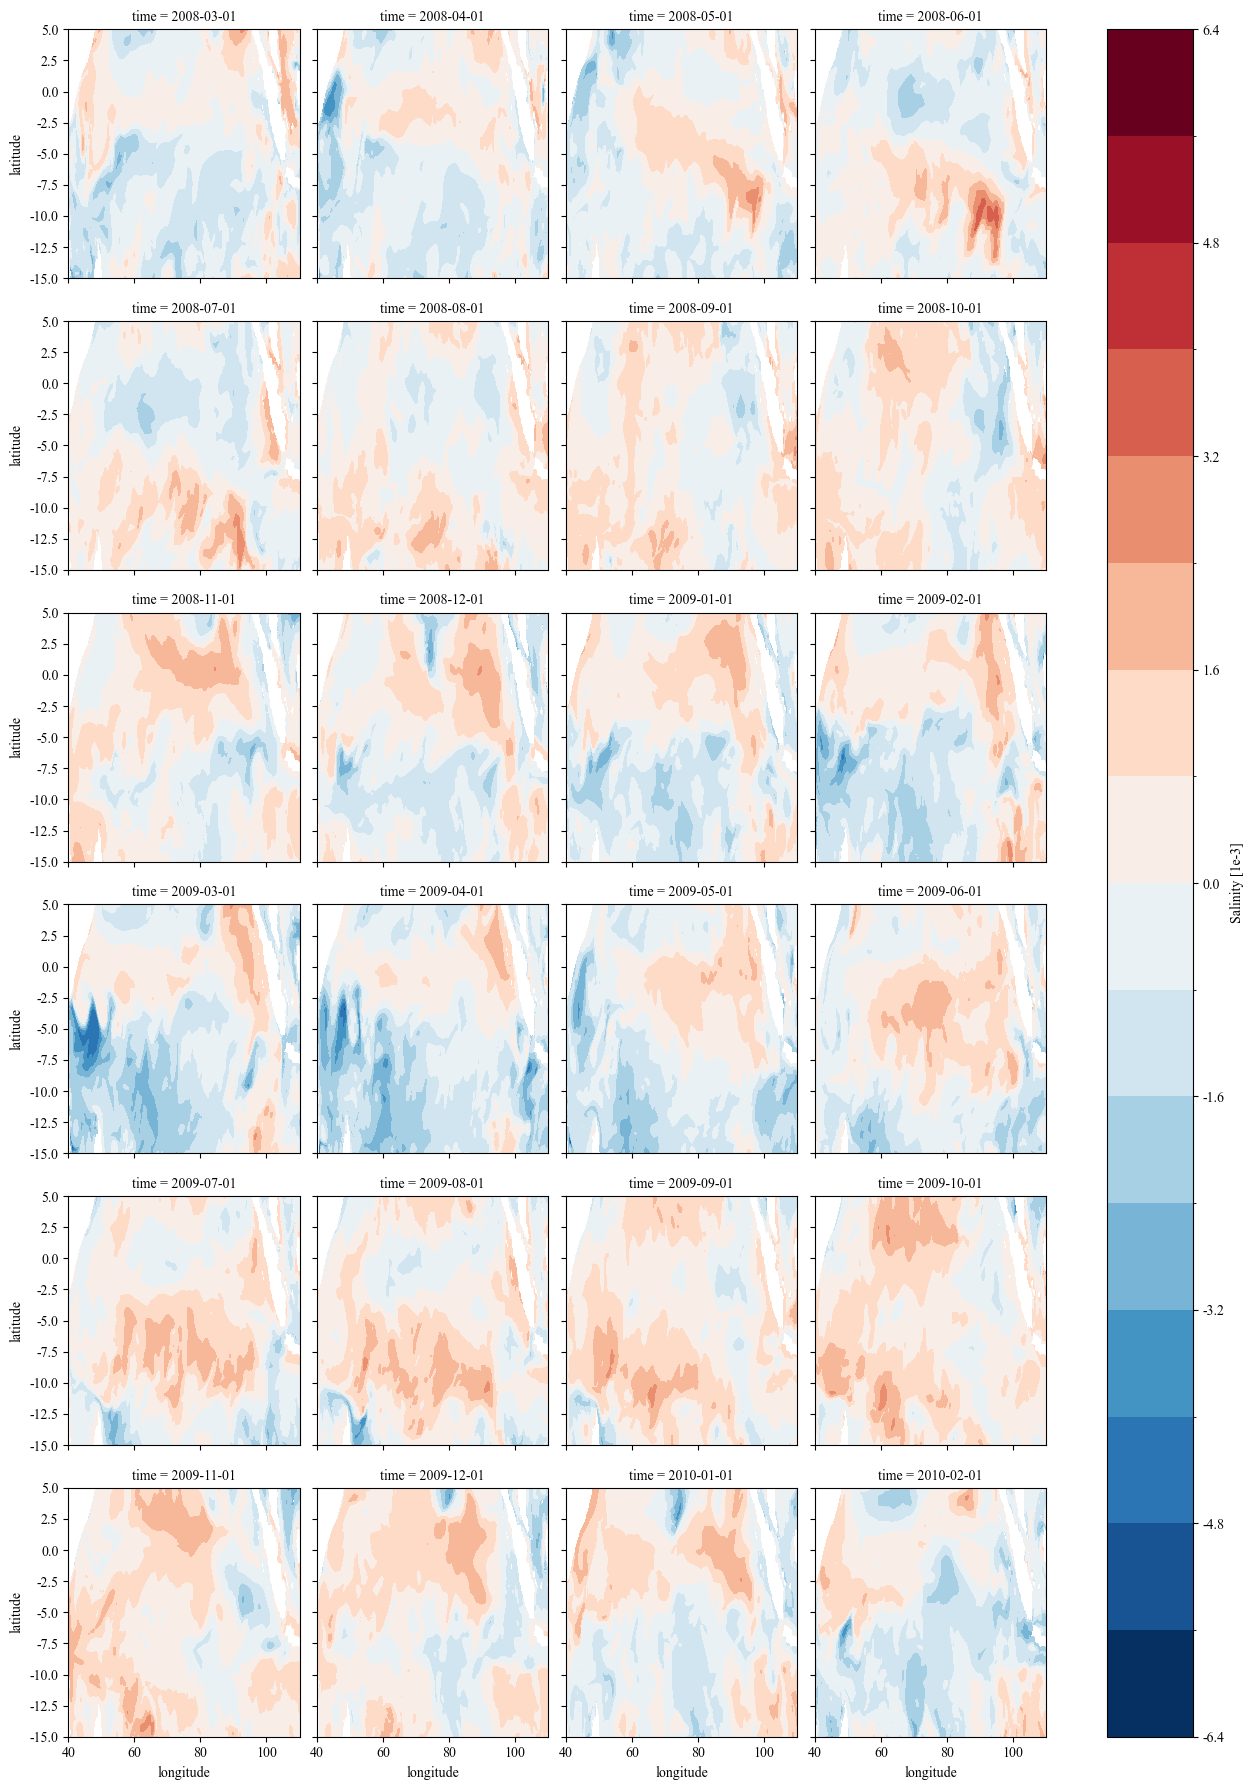

In [9]:
so = (so - so.mean(dim='time')) / so.std(dim='time')  #简单标准化
so.isel(time=slice(86, 110)).plot.contourf(x='longitude', col='time', col_wrap=4, cmap='RdBu_r', levels=20)

### 进行hilbert EOF
这里使用的是`xeofs`库
 * GitHub链接：https://github.com/xarray-contrib/xeofs?tab=readme-ov-file
 * 官方例子：https://xeofs.readthedocs.io/en/latest/content/user_guide/auto_examples/1single/plot_hilbert_eof.html#sphx-glr-content-user-guide-auto-examples-1single-plot-hilbert-eof-py
      
          
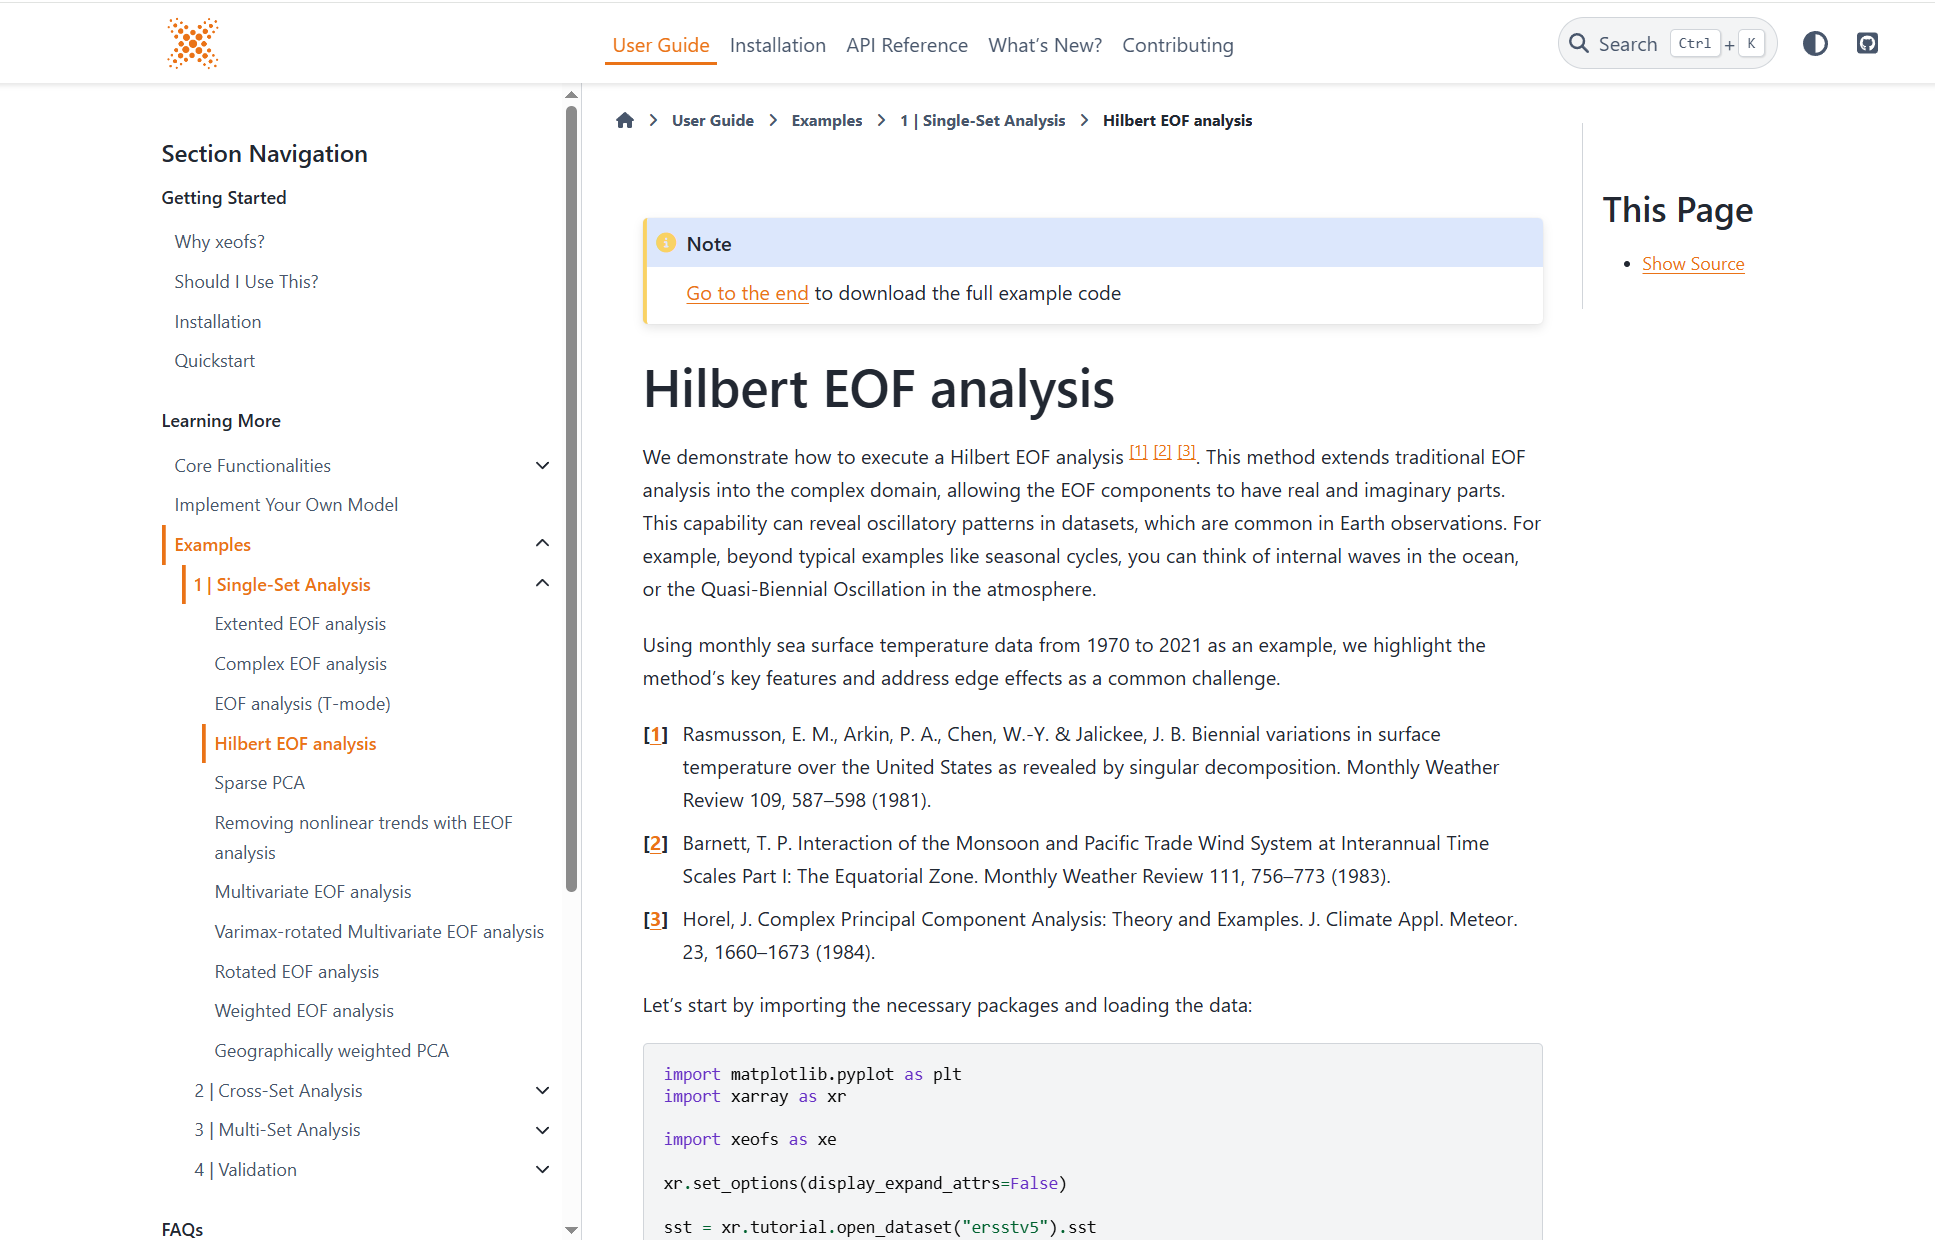

In [ ]:
def apply_Heof(da):  #自定义函数，输入参数为xarray.DataArray格式
    model = xe.single.HilbertEOF(n_modes=3, use_coslat=True, random_state=7, padding='exp') #生成HilbertEOF类的实例对象
    model.fit(da, dim='time') # 施以HilbertEOF分解
    eofs = model.components() #得到空间模态
    pcs = model.scores() #得到时间系数
    vars = model.explained_variance_ratio() #得到方差贡献度
    eofs_amp = model.components_amplitude() #得到空间模态振幅
    eofs_phase = model.components_phase() #得到空间模态相位
    pcs_amp = model.scores_amplitude() #得到时间系数振幅
    pcs_phase = model.scores_phase() #得到时间系数相位
    return eofs, pcs, vars, eofs_amp, eofs_phase, pcs_amp, pcs_phase #返回上面的参数

eofs, pcs, vars, eofs_amp, eofs_phase, pcs_amp, pcs_phase = apply_Heof(so) #应用函数在so上


c:\Users\Admin\anaconda3\envs\xeofs\Lib\site-packages\scipy\sparse\linalg\_eigen\_svds.py:477: UserWarning: Exited at iteration 20 with accuracies 
[0.00000044 0.00000036 0.00002177]
not reaching the requested tolerance 3.5762786865234375e-06.
Use iteration 21 instead with accuracy 
7.519360821052714e-06.

  _, eigvec = lobpcg(XH_X, X, tol=tol ** 2, maxiter=maxiter,
c:\Users\Admin\anaconda3\envs\xeofs\Lib\site-packages\scipy\sparse\linalg\_eigen\_svds.py:477: UserWarning: Exited postprocessing with accuracies 
[0.00000043 0.00000035 0.00002177]
not reaching the requested tolerance 3.5762786865234375e-06.
  _, eigvec = lobpcg(XH_X, X, tol=tol ** 2, maxiter=maxiter,


### 空间模态的分布
可以看到捕捉到了异常的南北传播信号(模态1和部分模态2)和东西传播信号(部分模态2和模态3)

Text(0.5, 0.99, 'eofs_amp')

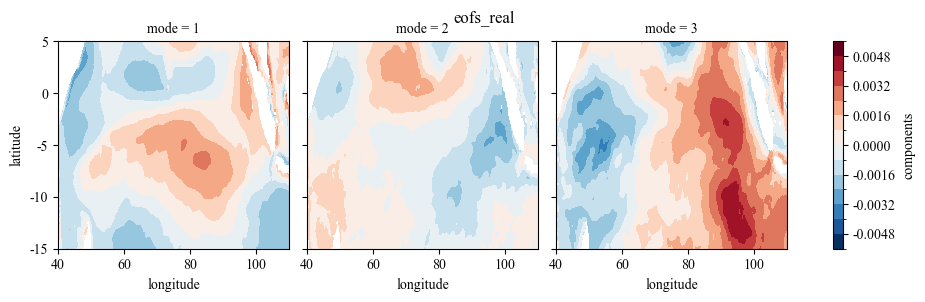

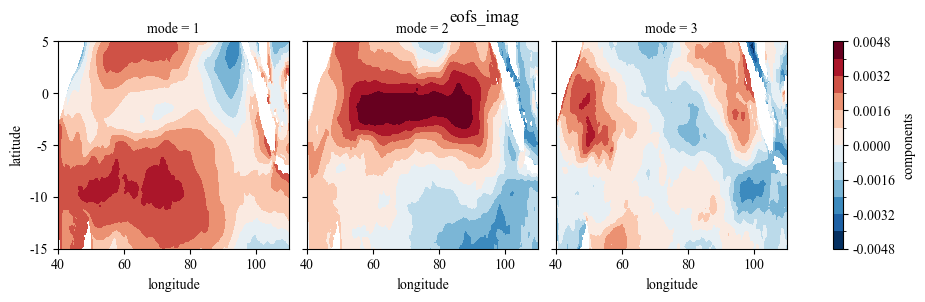

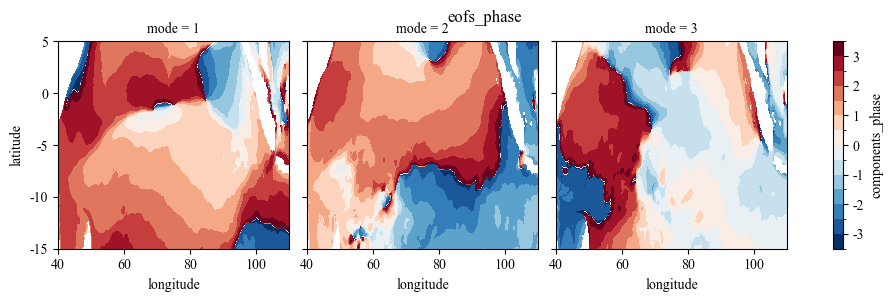

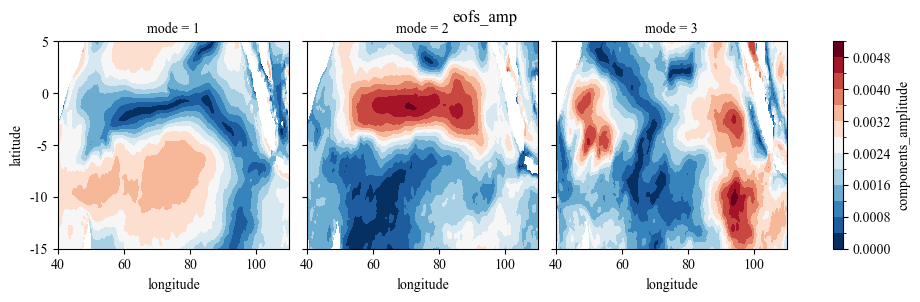

In [24]:
eofs.real.plot.contourf(col='mode', x='longitude', cmap='RdBu_r', levels=15)
plt.suptitle('eofs_real', y=0.99)
eofs.imag.plot.contourf(col='mode', x='longitude', cmap='RdBu_r', levels=15)
plt.suptitle('eofs_imag', y=0.99)
eofs_phase.plot.contourf(col='mode', x='longitude', cmap='RdBu_r', levels=15)
plt.suptitle('eofs_phase', y=0.99)
eofs_amp.plot.contourf(col='mode', x='longitude', cmap='RdBu_r', levels=15)
plt.suptitle('eofs_amp', y=0.99)

### 时间序列

Text(0.5, 0.99, 'pcs_amp')

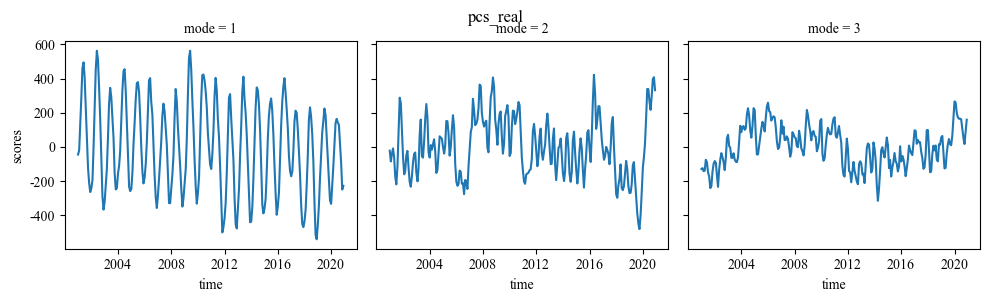

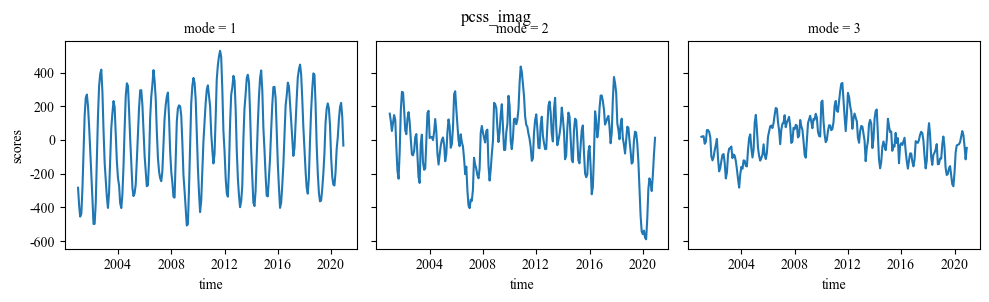

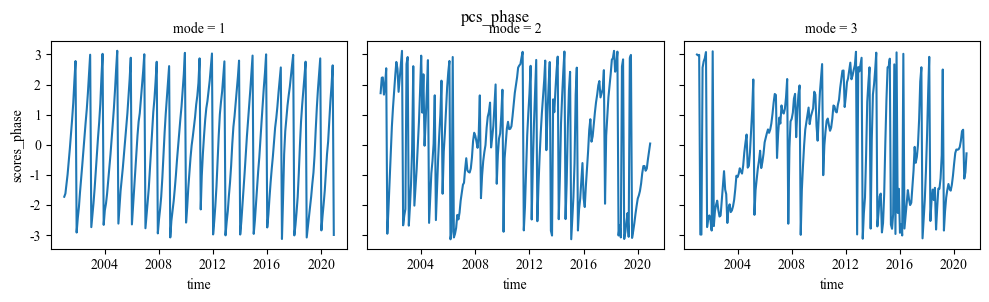

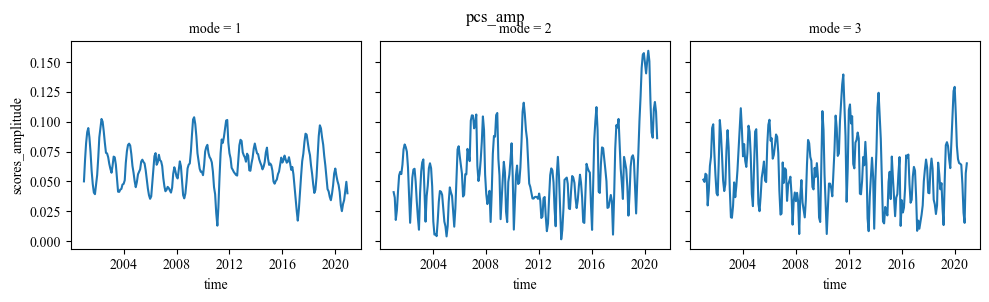

In [17]:
pcs.real.plot(col='mode', x='time')
plt.suptitle('pcs_real', y=0.99)
pcs.imag.plot(col='mode', x='time')
plt.suptitle('pcss_imag', y=0.99)
pcs_phase.plot(col='mode', x='time')
plt.suptitle('pcs_phase', y=0.99)
pcs_amp.plot(col='mode', x='time')
plt.suptitle('pcs_amp', y=0.99)